In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
from astropy.io import ascii
%pylab inline
import matplotlib
import matplotlib.colors as colors
from matplotlib.backends.backend_pdf import PdfPages
matplotlib.rcParams.update({'font.size': 6})

Populating the interactive namespace from numpy and matplotlib


In [2]:
#sns.reset_defaults()
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
sns.set_palette(sns.color_palette(["#9b59b6", 
                                   "#e74c3c", "#3498db", 
                                   "#34495e", "#2ecc71"]))
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
# Pandas reads from *lots* of different data sources
#data = pd.read_csv('../data/galaxy.csv', sep= ',') #MJ path
data = pd.read_csv('galaxynew.csv', sep= ',') #TUGBA path
#print(data)

In [4]:
central_mask = (data["StarFormationRate"]!=0)
array=data.to_numpy()
array = array[central_mask] #central_mask'daki maskelemenın aynısını tüm array olarak tanımladığı veriye uyguluyor.
array[:,10] = np.log10(array[:,10]/array[:,9]) #we use from here log SSFR(biz burdan log SSFR buluyoruz)
median_logssfr = np.median(array[:,10]) #we found the median logssfr for all the galaxies in Eagle
z_redshift=data['Redshift']
z_redshift=z_redshift[central_mask]

In [5]:
def central_filterer(logmmin, logmmax):
    """
    this function 
    keeps the central galaxies with non-zero SFR with logmstar 
    between logmmin, logmmax
    
    return:
    all galaxies with the above properties
    red galaxies with the baove properties
    blue galaxies with the above properties
    """
    
    central_mask = (data["SubGroupNumber"]==0)&(data["StarFormationRate"]!=0)
    array = data.to_numpy()
    array = array[central_mask]
    array[:,10] = np.log10(array[:,10]/array[:,9]) #biz burdan log SSFR
    array[:,9] = np.log10(array[:,9]) #buda logMstar
    reds = array[:,3] #redshift
    
    u_new = array[:,17]  
    r_new = array[:,19] 
    #ur_nodust = np.log10(u_nodust) - np.log10(r_nodust)
    ur_new = u_new - r_new
    ur_red = 2.21-0.65*(reds**0.6)
    ur_blue = 1.81-0.59*(reds**0.6)
    red_galaxy_mask = ur_new > ur_red
    blue_galaxy_mask = ur_new < ur_blue
    
    red = array[red_galaxy_mask,:]
    print(red)
    blue = array[blue_galaxy_mask,:]
    tot = array

    #u_new = array[u_nodust,:]
    #r_new = array[r_nodust,:]
    #ur_new = array[ur_nodust,:] 

    #return ur_new,r_new, u_new
    return tot,red,blue
#print(tot, red, blue)

def filterer(logmmin, logmmax):
    """
    this function 
    keeps the central galaxies with non-zero SFR with logmstar 
    between logmmin, logmmax
    
    return:
    all galaxies with the above properties
    red galaxies with the baove properties
    blue galaxies with the above properties
    """
    
    central_mask = (data["StarFormationRate"]!=0)
    array = data.to_numpy()
    array = array[central_mask]
    array[:,10] = np.log10(array[:,10]/array[:,9]) #biz burdan log SSFR
    array[:,9] = np.log10(array[:,9]) #buda logMstar
    reds = array[:,3]
    
    u_new = array[:,17]  
    r_new = array[:,19] 
    #ur_nodust = np.log10(u_nodust) - np.log10(r_nodust)
    ur_new = u_new - r_new
    ur_red = 2.21-0.65*(reds)**0.6
    ur_blue = 1.81-0.59*(reds)**0.6
    red_galaxy_mask = ur_new > ur_red
    blue_galaxy_mask = ur_new < ur_blue
    
    red = array[red_galaxy_mask,:]
    blue = array[blue_galaxy_mask,:]
    tot = array

    #u_new = array[u_nodust,:]
    #r_new = array[r_nodust,:]
    #ur_new = array[ur_nodust,:] 

    #return ur_new,r_new, u_new
    return tot,red,blue

def modify(x):
        
    mask = np.abs(x) > 50
    
    x[mask] = 100 - np.abs(x[mask])
    
    return np.abs(x)


def func(amin, bmax, data1, data2):
    
    """this function returns average number of 
    data1 points and data2 points between amin and bmax"""
    
    zebra = []

    for point in data1:
        
        matrix = point[None,:]-data2
        matrix = modify(matrix)
        
        distance_to_point = np.sum((matrix)**2  ,  axis = 1 )**0.5 #distance from all the points in fake data to the point
        A = (amin < distance_to_point) & ( distance_to_point < bmax)
        x = len(distance_to_point[A])
        zebra.append(x)
    zebra= np.array(zebra)
    return np.average(zebra)

def func2(logmin,logmmax, galaxy_type1, galaxy_type2):
    """
    it returns func at (2,4),(4,6) etc. sonun da (2,4) için net sonucu verir.  """
    
    ur_new, u_new, r_new = central_filterer(logmin, logmmax)
    #tot, red, blue = central_filterer(logmin, logmmax)
 
    
    if galaxy_type1 == 'red':
        FAKE_DATA1 = u_new[:,4:7] #bu demek ki biz tüm kolonı tutuyoruz ve sadece 4-7 arasındakı kolonları seçiyoruz.
    if galaxy_type1 == 'blue':
        FAKE_DATA1 = r_new[:,4:7]
    if galaxy_type1 == 'tot':
        FAKE_DATA1 = ur_new[:,4:7]
   
    ur_new, u_new, r_new = central_filterer(logmin, logmmax) # filterer gives us all galaxies but central_filterer gives us just center galaxies.
    
    #print "tot shape", tot.shape , red.shape , blue.shape

    if galaxy_type2 == 'red':
        FAKE_DATA2 = u_new[:,4:7]
    if galaxy_type2 == 'blue':   #sns.distplot(array[:,10], norm_hist=False,kde=False)
        FAKE_DATA2 = r_new[:,4:7]
    if galaxy_type2 == 'tot':
        FAKE_DATA2 = ur_new[:,4:7]
    
    list_average = []
    
    lister = [2,3,4,5,6,8,9,10,11,12]
    for i in lister:
        average = func(i,i+1,FAKE_DATA1,FAKE_DATA2)
        list_average.append(average)
    return np.array(list_average)

In [6]:
#def central_filterer(logmmin, logmmax):

 #   u_nodust = array[:,17] < median_logssfr  
  #  r_nodust = array[:,19] > median_logssfr 
  #  ur_nodust = np.log10(u_nodust) - np.log10(r_nodust) 

   # u_new = array[u_nodust,:]
    #r_new = array[r_nodust,:]
    #ur_new = array[ur_nodust,:] 


#print(u_new)
#print(r_nodust)
#print(ur_new)

In [7]:
def edge(index , nsub):
    '''returns edges of a sub-box of 
       a given index
    '''
    box_size = 100.
    subbox_size = 1.*box_size / nsub

    zi = (index / (nsub**2)) * subbox_size
    i2 = index % (nsub**2)
    yi = (i2 / nsub) * subbox_size
    i3 = i2 % nsub
    xi = (i3) * subbox_size

    return xi , yi , zi

def mask_catalog(cat , subvol_index , nsub):
    '''This divides the box into nsub^3 
       sub-boxes. And then it takes out 
       the sub-box ccorresponding to subvol_index!
       Boom!
    '''
    box_size = 100
    subbox_size = 1.*box_size / nsub
    
    xi , yi , zi  = edge(subvol_index, nsub)
    submask = (xi <cat[:, 4]) * \
                       (cat[:, 4] < xi + subbox_size) * \
                       (yi <cat[:, 5]) * \
                       (cat[:, 5] < yi + subbox_size) * \
                       (zi <cat[:, 6]) *  \
                       (cat[:, 6] < zi + subbox_size)
    
    #print cat.shape , cat[~submask,:].shape
    return cat[~submask]

In [8]:
def func_index(amin, bmax, data1, data2):
    
    """this function returns average number of 
    data1 points and data2 points between amin and bmax"""
    
    zebra = []

    for point in data1:
        
        matrix = point[None,:]-data2
        matrix = modify(matrix)
        
        distance_to_point = np.sum((matrix)**2  ,  axis = 1 )**0.5 #distance from all the points in fake data to the point
        A = (amin < distance_to_point) & ( distance_to_point < bmax)
        x = len(distance_to_point[A])
        zebra.append(x)
    zebra= np.array(zebra)
    return np.average(zebra)

def func2_index(logmin,logmmax, galaxy_type1, galaxy_type2, index, nsub):
    """
    it returns func at (2,4),(4,6) etc. sonun da (2,4) için net sonucu verir.  """
    
    ur_new, u_new, r_new = central_filterer(logmin, logmmax)
    
    ur_new, u_new, r_new = mask_catalog(ur_new, index, nsub), mask_catalog(u_new, index, nsub), mask_catalog(r_new, index, nsub)
    
    
    if galaxy_type1 == 'u_new':
        FAKE_DATA1 = u_new[:,4:7] #bu demek ki biz tüm kolonı tutuyoruz ve sadece 4-7 arasındakı kolonları seçiyoruz.
    if galaxy_type1 == 'r_new':
        FAKE_DATA1 = r_new[:,4:7]
    if galaxy_type1 == 'ur_new':
        FAKE_DATA1 = ur_new[:,4:7]
   
    ur_new, u_new, r_new = central_filterer(logmin, logmmax) # filterer gives us all galaxies but central_filterer gives us just center galaxies.
    


    if galaxy_type2 == 'u_new':
        FAKE_DATA2 = u_new[:,4:7]
    if galaxy_type2 == 'r_new':   #sns.distplot(array[:,10], norm_hist=False,kde=False)
        FAKE_DATA2 = r_new[:,4:7]
    if galaxy_type2 == 'ur_new':
        FAKE_DATA2 = ur_new[:,4:7]
    
    list_average = []
    
    lister = [2,3,4,5,6,8,9,10,11,12]
    for i in lister:
        average = func(i,i+1,FAKE_DATA1,FAKE_DATA2)
        list_average.append(average)

    return np.array(list_average)

In [9]:
def red_fraction(logmmin, logmmax, nsub):
    
    tot_red_subs = []
    red_red_subs = []
    tot_blue_subs = []
    red_blue_subs = []

    for index in range(nsub**3):
        
        tot_red_subs.append(func2_index(logmmin,logmmax,'red','tot', index, nsub))
        red_red_subs.append(func2_index(logmmin,logmmax,'red','red', index, nsub))
        tot_blue_subs.append(func2_index(logmmin,logmmax,'blue','tot', index, nsub))
        red_blue_subs.append(func2_index(logmmin,logmmax,'blue','red', index, nsub))

        
    tot_red_subs = np.array(tot_red_subs)
    red_red_subs = np.array(red_red_subs)
    tot_blue_subs = np.array(tot_blue_subs)
    red_blue_subs = np.array(red_blue_subs)

    tot_red_errs =  np.cov(tot_red_subs.T) * (nsub ** 3 - 1)**2 /nsub ** 3  
    red_red_errs =  np.cov(red_red_subs.T) * (nsub ** 3 - 1)**2 / nsub ** 3
    tot_blue_errs = np.cov(tot_blue_subs.T) * (nsub ** 3 - 1)**2 / nsub ** 3
    red_blue_errs =  np.cov(red_blue_subs.T) *(nsub ** 3 - 1)**2 /nsub ** 3
    
    
    tot_red_err = np.diag(tot_red_errs)**.5
    red_red_err = np.diag(tot_red_errs)**.5
    tot_blue_err = np.diag(tot_blue_errs)**.5
    red_blue_err = np.diag(red_blue_errs)**.5
    
    
    tot_red = func2(logmmin,logmmax,'red','tot')
    red_red = func2(logmmin,logmmax,'red','red')
    tot_blue = func2(logmmin,logmmax,'blue','tot')
    red_blue = func2(logmmin,logmmax,'blue','red')
    
    fred_red = np.array(red_red)*1.  / np.array(tot_red) #equation 1 of paper
    fred_blue = np.array(red_blue)*1.  / np.array(tot_blue) #equatıon 2 of paper
    
    var_fred_red = (red_red_err**2/red_red**2 + tot_red_err**2/tot_red**2)*(red_red/tot_red)**2.
    fred_red_err = var_fred_red**.5
    
    var_fred_blue = (red_blue_err**2/red_blue**2 + tot_blue_err**2/tot_blue**2)*(red_blue/tot_blue)**2.
    fred_blue_err = var_fred_blue**.5
    
    return fred_red, fred_red_err, fred_blue, fred_blue_err

In [10]:
def chi2(red_red, red_red_err, red_blue, red_blue_err):
    
    ndata = len(red_red)
    chi2r = (red_red - red_blue)**2./(red_red_err**2. + red_blue_err**2.)
    return np.sum(chi2r/ndata)

In [11]:
def process(logm_list, delta_logm):
    
    logm_max_list = logm_list + delta_logm/2.
    logm_min_list = logm_list - delta_logm/2.
    
    frr, frr_err, frb, frb_err = [],[],[],[]
    
    for i in range(len(logm_list)):
        
        A, B, C, D = red_fraction(logm_min_list[i], logm_max_list[i], 3)
        frr.append(A)
        frr_err.append(B)
        frb.append(C)
        frb_err.append(D)
        
    frr = np.array(frr)
    frr_err = np.array(frr_err)
    frb = np.array(frb)
    frb_err = np.array(frb_err)
    
    return frr, frr_err, frb, frb_err

In [12]:
logm_list = np.array([9.6, 9.8, 10, 10.2, 10.4, 10.6])
delta_logm = 0.2

In [13]:
frr, frr_err, frb, frb_err = process(logm_list, delta_logm)

[[ 4.7117560e+06  2.8000100e+13  2.8000000e+01 ... -1.7103260e+01
  -1.7821964e+01 -1.8136976e+01]
 [ 4.3083280e+06  2.8000100e+13  2.8000000e+01 ... -1.6190390e+01
  -1.6913252e+01 -1.7231340e+01]
 [ 9.0293720e+06  2.8000000e+13  2.8000000e+01 ... -1.9686468e+01
  -2.0480558e+01 -2.0821890e+01]
 ...
 [ 1.8314859e+07  2.8000000e+13  2.8000000e+01 ... -2.0273329e+01
  -2.1026490e+01 -2.1357473e+01]
 [ 1.8320343e+07  2.8000000e+13  2.8000000e+01 ... -1.9251806e+01
  -1.9985641e+01 -2.0311730e+01]
 [ 1.8382838e+07  2.8000000e+13  2.8000000e+01 ... -2.0223133e+01
  -2.0989412e+01 -2.1323400e+01]]
[[ 4.7117560e+06  2.8000100e+13  2.8000000e+01 ... -1.7103260e+01
  -1.7821964e+01 -1.8136976e+01]
 [ 4.3083280e+06  2.8000100e+13  2.8000000e+01 ... -1.6190390e+01
  -1.6913252e+01 -1.7231340e+01]
 [ 9.0293720e+06  2.8000000e+13  2.8000000e+01 ... -1.9686468e+01
  -2.0480558e+01 -2.0821890e+01]
 ...
 [ 1.8314859e+07  2.8000000e+13  2.8000000e+01 ... -2.0273329e+01
  -2.1026490e+01 -2.1357473e+01]

UnboundLocalError: local variable 'FAKE_DATA1' referenced before assignment

NameError: name 'frr' is not defined

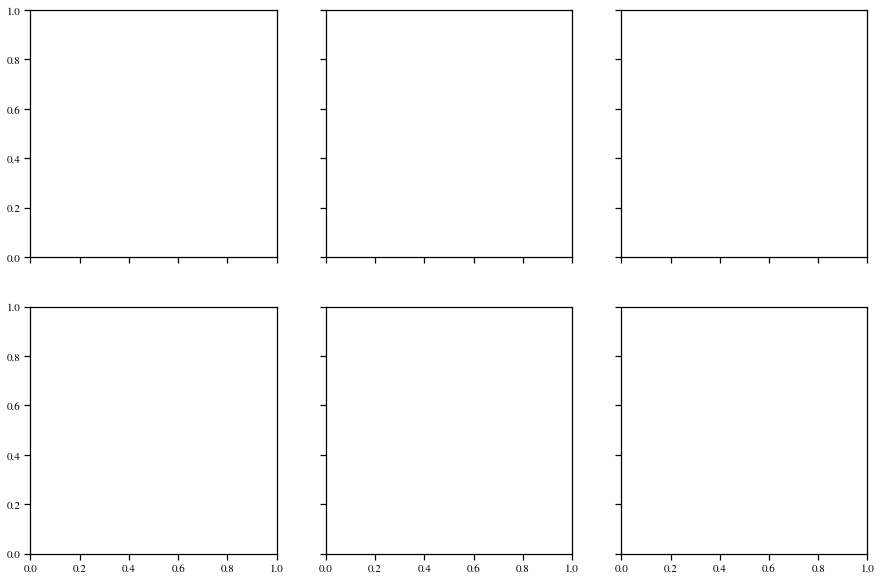

In [14]:
x = [2.5 +i for i in range(10)]
x = np.array(x)

fig , ax = plt.subplots(nrows=2,ncols=3 , figsize=(15,10), sharex=True, sharey=True)

for i in range(2):
    for j in range(3):
        if i == 0:
            ax[i,j].errorbar(x , frr[i+j,:]-frb[i+j,:], 
                             (frr_err[i+j,:]**2+frb_err[i+j,:]**2)**.5 , fmt = "o", color = "#9b59b6")
            ax[i,j].axhline(0)
            chi = chi2(frr[i+j,:],frr_err[i+j,:], frb[i+j,:], frb_err[i+j,:])
            ax[i,j].text(3, 0.6, r"$\log M_{\star}=$"+str(logm_list[i+j])+r"$, \;\chi^{2}/\nu \; =$"+str(np.round(chi,2)) , fontsize = 20)

            ax[i,j].set_ylim([-0.45,.9])  
        if  i > 0: 
            ax[i,j].errorbar(x , frr[3+j,:]-frb[i+j,:], 
                             (frr_err[3+j,:]**2+frb_err[i+j,:]**2)**.5, fmt = "o", color = "#9b59b6")
            ax[i,j].axhline(0)

            chi = chi2(frr[3+j,:],frr_err[3+j,:], frb[3+j,:], frb_err[3+j,:])
            ax[i,j].text(3, 0.6, r"$\log M_{\star}=$"+str(logm_list[3+j])+r"$, \;\chi^{2}/\nu \; =$"+str(np.round(chi,2)) , fontsize = 20)
            ax[i,j].set_ylim([-0.45,.9])

#ax[0,0].legend(('Quenched primary', 'Star forming primary'), loc='lower right', shadow=False , fontsize = 15)
            
            
ax[0,0].tick_params(axis='both', labelsize=15)
ax[1,0].tick_params(axis='both', labelsize=15)
ax[1,1].tick_params(axis='both', labelsize=15)
ax[1,2].tick_params(axis='both', labelsize=15)

ax[0,0].set_ylabel("$\Delta \;f_{\mathrm{Q, \; central}}$", fontsize = 30)
ax[1,0].set_ylabel("$\Delta \; f_{\mathrm{Q, \; central}}$", fontsize = 30)
ax[1,0].set_xlabel("$r \; [\mathrm{Mpc}]$", fontsize = 30)
ax[1,1].set_xlabel("$r \; [\mathrm{Mpc}]$", fontsize = 30)
ax[1,2].set_xlabel("$r \; [\mathrm{Mpc}]$", fontsize = 30)

plt.savefig(pp2, format='pdf')
#An easier way is to call PdfPages.savefig: pp.savefig()
pp2.close()